## Introduction to Massive Data Analysis 
### HW3 - K-means
106070038 杜葳葳

匯入 SparkConf、SparkContext、Pyspark模組<br>
設定環境變數（解決版本問題）

In [1]:
# import package
from pyspark import SparkConf,SparkContext
import pyspark
from numpy import array
import csv

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# set environment variables
import os
os.environ["PYSPARK_PYTHON"]="/Library/Frameworks/Python.framework/Versions/3.8/bin/python3.8"
os.environ['PYSPARK_DRIVER_PYTHON'] = '/Library/Frameworks/Python.framework/Versions/3.8/bin/python3.8'

建立 SparkConf 物件<br>
設為 local 模式、名稱設為 "hw3"

In [2]:
sc.stop()

In [3]:
conf = SparkConf().setMaster("local").setAppName("hw3")
sc = SparkContext(conf=conf)
sc

<SparkContext master=local appName=hw3>

### 讀檔

In [4]:
dataSet = sc.textFile("data.txt").map(lambda line: array([float(x) for x in line.split(' ')]))
c1 = sc.textFile("c1.txt").map(lambda line: array([float(x) for x in line.split(' ')]))
c2 = sc.textFile("c2.txt").map(lambda line: array([float(x) for x in line.split(' ')]))
dataSet.take(1)

[array([  0.   ,   0.64 ,   0.64 ,   0.   ,   0.32 ,   0.   ,   0.   ,
          0.   ,   0.   ,   0.   ,   0.   ,   0.64 ,   0.   ,   0.   ,
          0.   ,   0.32 ,   0.   ,   1.29 ,   1.93 ,   0.   ,   0.96 ,
          0.   ,   0.   ,   0.   ,   0.   ,   0.   ,   0.   ,   0.   ,
          0.   ,   0.   ,   0.   ,   0.   ,   0.   ,   0.   ,   0.   ,
          0.   ,   0.   ,   0.   ,   0.   ,   0.   ,   0.   ,   0.   ,
          0.   ,   0.   ,   0.   ,   0.   ,   0.   ,   0.   ,   0.   ,
          0.   ,   0.   ,   0.778,   0.   ,   0.   ,   3.756,  61.   ,
        278.   ,   1.   ])]

### 加上index
**zipWithIndex()**<br>
Zips this RDD with its element indices.<br>
The ordering is first based on the partition index and then the ordering of items within each partition. So the first item in the first partition gets index 0, and the last item in the last partition receives the largest index.

In [5]:
data_index = dataSet.zipWithIndex().map(lambda x: (x[1],x[0]))
c1_index = c1.zipWithIndex().map(lambda x: (x[1],x[0]))
c2_index = c2.zipWithIndex().map(lambda x: (x[1],x[0]))
data_index.take(1)

[(0,
  array([  0.   ,   0.64 ,   0.64 ,   0.   ,   0.32 ,   0.   ,   0.   ,
           0.   ,   0.   ,   0.   ,   0.   ,   0.64 ,   0.   ,   0.   ,
           0.   ,   0.32 ,   0.   ,   1.29 ,   1.93 ,   0.   ,   0.96 ,
           0.   ,   0.   ,   0.   ,   0.   ,   0.   ,   0.   ,   0.   ,
           0.   ,   0.   ,   0.   ,   0.   ,   0.   ,   0.   ,   0.   ,
           0.   ,   0.   ,   0.   ,   0.   ,   0.   ,   0.   ,   0.   ,
           0.   ,   0.   ,   0.   ,   0.   ,   0.   ,   0.   ,   0.   ,
           0.   ,   0.   ,   0.778,   0.   ,   0.   ,   3.756,  61.   ,
         278.   ,   1.   ]))]

### cartesian 取得 pair
**cartesian(other)**<br>
Return the Cartesian product of this RDD and another one, that is, the RDD of all pairs of elements (a, b) where a is in self and b is in other.<br>
abs(): 計算 Manhattan cost<br>
平方: 計算 Euclidean cost<br>
sum(): 加總<br>
重新mapping

In [6]:
## return (i, [j, Manhattan distance sum, Euclidean distance sum])
## ex.(0, [0, 289.6426000000001, 78033.06652467705])
def get_count(data, cluster):
    return data.cartesian(cluster)\
        .map(lambda x : ((x[0][0],x[1][0]), x[0][1]-x[1][1]))\
        .map(lambda x : (x[0],(abs(x[1]),x[1]**2)))\
        .map(lambda x : (x[0],(sum(x[1][0]),sum(x[1][1]))))\
        .map(lambda x : (x[0][0],[x[0][1],x[1][0],x[1][1] ] ))

### 計算各個cluster兩兩間的距離
與 get_count() 類似<br>
但因為是distance 所以 Euclidean 要開根號

In [7]:
def get_distance(data, cluster):
    return data.cartesian(cluster)\
        .map(lambda x : ((x[0][0],x[1][0]), x[0][1]-x[1][1]))\
        .map(lambda x : (x[0],(abs(x[1]),x[1]**2)))\
        .map(lambda x : (x[0],(sum(x[1][0]),sum(x[1][1])**0.5)))\
        .map(lambda x : (x[0][0],x[0][1],x[1][0],x[1][1]))

### 尋找距離最短的cluster
if "<" 就更新

In [8]:
def manhattan_reduce(distance_sum):
    return distance_sum.reduceByKey(lambda x,y : x if x[1]<=y[1] else y)
def euclidean_reduce(distance_sum):
    return distance_sum.reduceByKey(lambda x,y : x if x[2]<=y[2] else y)

### 取得新的cluster

In [9]:
def find_centriods(data_index, cluster_table):
    return cluster_table.join(data_index).map(lambda x: (x[1][0], (1,x[1][1])))\
                  .reduceByKey(lambda x,y : (x[0]+y[0],x[1]+y[1]))\
                  .map(lambda x : (x[0],x[1][1]/x[1][0]))

### 寫至csv檔

In [10]:
def toCSVLine(data):
    return ','.join(str(d) for d in data)

建立一個dataframe來記錄每次iterate的cost

In [11]:
import pandas as pd
series1 = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]
series = ['i','man','euc']
ans = pd.DataFrame(index=series,columns=series1)
ans2 = pd.DataFrame(index=series,columns=series1)
ans3 = pd.DataFrame(index=series,columns=series1)
ans4 = pd.DataFrame(index=series,columns=series1)

### (a) Initialization strategies with Euclidean distance
#### C1
重覆20次迴圈<br><br>
計算所有點對於所有cluster的距離<br>
使用data的index做reduceByKey，取得所有cluster中距離最小的距離<br>
分別用sum得到兩種距離，並加到list中<br>
建立cluster_table來區辨每個點是屬於哪個cluster<br>
重新map然後reduce取得新的cluster

In [12]:
cluster = c1_index
cluster.persist()
c1_man_list = []
c1_euc_list = []

for i in range(20):
    
    distance_sum = get_count(data_index,cluster)

    manhattan_cost = manhattan_reduce(distance_sum).map(lambda x : x[1][1]).sum()
    euclidean = euclidean_reduce(distance_sum)
    euclidean_cost = euclidean.map(lambda x : x[1][2]).sum()
    
    c1_man_list.append(manhattan_cost)
    c1_euc_list.append(euclidean_cost)

    ans.iloc[0,i] = i
    ans.iloc[1,i] = round(manhattan_cost,3)
    ans.iloc[2,i] = round(euclidean_cost,3)
    
    print("Iteration %d: %f" % (i,euclidean_cost))
    
    ## update centriod
    cluster_table = euclidean.map(lambda x : (x[0],x[1][0]))
    cluster = find_centriods(data_index, cluster_table)
    
    ## output the distance between different centroids by Manhattan and Euclidean
    sheet = get_distance(cluster, cluster)

    ## when iterate 20 times, print the distance between cluster
    if i==19:
        lines = sheet.map(toCSVLine)
        lines.repartition(1).saveAsTextFile('output_euc_c1_19.csv')
    
    cluster.persist()
    
ans.to_csv('sheet_1.csv', index=False, header=False )

Iteration 0: 623660345.306423
Iteration 1: 509862908.297546
Iteration 2: 485480681.872008
Iteration 3: 463997011.685014
Iteration 4: 460969266.572996
Iteration 5: 460537847.982768
Iteration 6: 460313099.653545
Iteration 7: 460003523.889407
Iteration 8: 459570539.317735
Iteration 9: 459021103.342291
Iteration 10: 458490656.191981
Iteration 11: 457944232.587974
Iteration 12: 457558005.198677
Iteration 13: 457290136.352302
Iteration 14: 457050555.059562
Iteration 15: 456892235.615355
Iteration 16: 456703630.737034
Iteration 17: 456404203.018975
Iteration 18: 456177800.541993
Iteration 19: 455986871.027346


#### C2

In [13]:
cluster = c2_index
cluster.persist()
c2_man_list = []
c2_euc_list = []
for i in range(20):
    
    distance_sum = get_count(data_index,cluster)

    manhattan_cost = manhattan_reduce(distance_sum).map(lambda x : x[1][1]).sum()
    euclidean = euclidean_reduce(distance_sum)
    euclidean_cost = euclidean.map(lambda x : x[1][2]).sum()
    
    c2_man_list.append(manhattan_cost)
    c2_euc_list.append(euclidean_cost)

    ans2.iloc[0,i] = i
    ans2.iloc[1,i] = round(manhattan_cost,3)
    ans2.iloc[2,i] = round(euclidean_cost,3)
    
    print("Iteration %d:  %f" % (i,euclidean_cost))
    
    ## update centriod
    cluster_table = euclidean.map(lambda x : (x[0],x[1][0]))
    cluster = find_centriods(data_index, cluster_table)
    
    ## output the distance between different centroids by Manhattan and Euclidean
    sheet = get_distance(cluster, cluster)
    
    if i==19:
        lines = sheet.map(toCSVLine)
        lines.repartition(1).saveAsTextFile('output_euc_c2_19.csv')
    
    cluster.persist()
    
ans2.to_csv('sheet_2.csv', index=False, header=False )

Iteration 0:  438747790.027918
Iteration 1:  249803933.626003
Iteration 2:  194494814.406312
Iteration 3:  169804841.451543
Iteration 4:  156295748.806276
Iteration 5:  149094208.108966
Iteration 6:  142508531.619615
Iteration 7:  132303869.406530
Iteration 8:  117170969.837191
Iteration 9:  108547377.178570
Iteration 10:  102237203.317996
Iteration 11:  98278015.749757
Iteration 12:  95630226.121774
Iteration 13:  93793314.051193
Iteration 14:  92377131.968211
Iteration 15:  91541606.254239
Iteration 16:  91045573.830425
Iteration 17:  90752240.101408
Iteration 18:  90470170.181227
Iteration 19:  90216416.175631


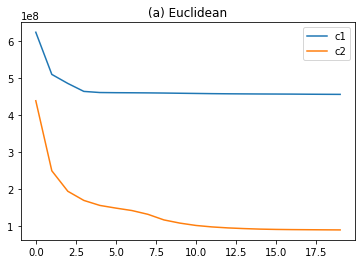

In [14]:
plt.plot(c1_euc_list, label="c1")
plt.plot(c2_euc_list, label = "c2")
plt.legend(loc='upper right')
plt.title("(a) Euclidean")
plt.show()

### (b) Initialization strategies with Manhattan distance
#### C1
與(a)大致相同<br>
僅差在update時用Manhattan

In [15]:
cluster = c1_index
cluster.persist()
c1_man_list = []
c1_euc_list = []
for i in range(20):
    
    distance_sum = get_count(data_index,cluster)

    manhattan = manhattan_reduce(distance_sum)
    manhattan_cost = manhattan.map(lambda x : x[1][1]).sum()
    euclidean_cost = euclidean_reduce(distance_sum).map(lambda x : x[1][2]).sum()
    
    c1_man_list.append(manhattan_cost)
    c1_euc_list.append(euclidean_cost)

    ans3.iloc[0,i] = i
    ans3.iloc[1,i] = round(manhattan_cost,3)
    ans3.iloc[2,i] = round(euclidean_cost,3)
    
    print("Iteration %d: %f" % (i,manhattan_cost))
    
    ## update centriod
    cluster_table = manhattan.map(lambda x : (x[0],x[1][0]))
    cluster = find_centriods(data_index, cluster_table)
    
    ## output the distance between different centroids by Manhattan and Euclidean
    sheet = get_distance(cluster, cluster)
    
    if i==19:
        lines = sheet.map(toCSVLine)
        lines.repartition(1).saveAsTextFile('output_man_c1_19.csv')
    
    cluster.persist()
    
ans3.to_csv('sheet_3.csv', index=False, header=False )

Iteration 0: 550117.142000
Iteration 1: 464869.275879
Iteration 2: 470897.382277
Iteration 3: 483914.409173
Iteration 4: 489216.071003
Iteration 5: 487629.668550
Iteration 6: 483711.923214
Iteration 7: 475330.773493
Iteration 8: 474871.238846
Iteration 9: 457232.920115
Iteration 10: 447494.386197
Iteration 11: 450915.012577
Iteration 12: 451250.367073
Iteration 13: 451974.595540
Iteration 14: 451570.364070
Iteration 15: 452739.011366
Iteration 16: 453082.730287
Iteration 17: 450583.670860
Iteration 18: 450368.749317
Iteration 19: 449011.363726


#### Initial points: C2

In [16]:
cluster = c2_index
cluster.persist()
c2_man_list = []
c2_euc_list = []
for i in range(20):
    
    distance_sum = get_count(data_index,cluster)

    manhattan = manhattan_reduce(distance_sum)
    manhattan_cost = manhattan.map(lambda x : x[1][1]).sum()
    euclidean_cost = euclidean_reduce(distance_sum).map(lambda x : x[1][2]).sum()
    
    c2_man_list.append(manhattan_cost)
    c2_euc_list.append(euclidean_cost)

    ans4.iloc[0,i] = i
    ans4.iloc[1,i] = round(manhattan_cost,3)
    ans4.iloc[2,i] = round(euclidean_cost,3)
    print("Iteration %d: %f" % (i,manhattan_cost))
    
    ## update centriod
    cluster_table = manhattan.map(lambda x : (x[0],x[1][0]))
    cluster = find_centriods(data_index, cluster_table)
    
    ## output the distance between different centroids by Manhattan and Euclidean
    sheet = get_distance(cluster, cluster)
    
    if i==19:
        lines = sheet.map(toCSVLine)
        lines.repartition(1).saveAsTextFile('output_man_c2_19.csv')
    
    cluster.persist()
    
ans4.to_csv('sheet_4.csv', index=False, header=False )

Iteration 0: 1433739.310000
Iteration 1: 1084488.776965
Iteration 2: 973431.714662
Iteration 3: 895934.592563
Iteration 4: 865128.335294
Iteration 5: 845846.647031
Iteration 6: 827219.582756
Iteration 7: 803590.345601
Iteration 8: 756039.517276
Iteration 9: 717332.902543
Iteration 10: 694587.925253
Iteration 11: 684444.501997
Iteration 12: 674574.747548
Iteration 13: 667409.469916
Iteration 14: 663556.627822
Iteration 15: 660162.777229
Iteration 16: 656041.322295
Iteration 17: 653036.754073
Iteration 18: 651112.426252
Iteration 19: 649689.013184


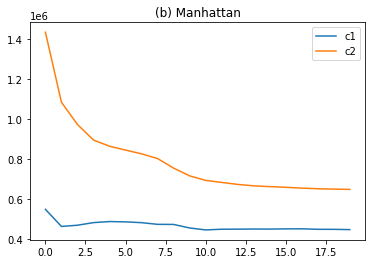

In [17]:
plt.plot(c1_man_list, label = "c1")
plt.plot(c2_man_list, label = "c2")
plt.legend(loc='upper right')
plt.title("(b) Manhattan")
plt.show()

### 將資料整理後輸出成表格

In [ ]:
import pandas as pd
data_1 = pd.read_csv('output_man_c2_19.csv')

series = [1,2,3,4,5,6,7,8,9,10]
ans = pd.DataFrame(index=series,columns=series)

In [ ]:
for i in range(10):
    for j in range(10):
        if i<j:
            buf = data_1.loc[data_1['0'] == i]
            buf_2 = buf.loc[buf['0.1'] == j]
            ## x1 = buf_2.iloc[0,2]
            x1 = buf_2.iloc[0,3]
            print(buf_2.iloc[0,3])
            ans.iloc[i,j] = round(x1,3)

In [ ]:
print(ans)
ans.to_csv('ans_1.csv', index=True, header=True )

圖表與說明寫在PDF檔的report中